# Exploratory Clustering

This notebook is just meant to do some initial exploratory clustering on top of the different types of data that we have downloaded and analyze some of the results of the initial clusters formed. The analysis includes purity measure and distance between clusters

## Importing Required Libraries

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import glob
import pickle

from utils.directory_utils import *
from utils.general_utils import *

from sklearn.cluster import KMeans
from nltk.cluster import KMeansClusterer
from scipy.spatial.distance import euclidean
import fastdtw
from sklearn.decomposition import PCA

## Data

### Loading Heart Rate Time Series Data

In [22]:
heart_rate_data_directory_path = f'../data/data_files/Saksham/heart/'
all_heart_rate_data = []
for file_path in glob.glob(heart_rate_data_directory_path + '*.pickle'):
    heart_rate_data_raw = pickle.load(open(file_path, 'rb'))
    day_heart_rate_data_array = get_attribute_val_array_by_minute(heart_rate_data_raw, 'value')
    if day_heart_rate_data_array.shape != (0,) and not np.isnan(day_heart_rate_data_array).all():
        day_heart_rate_data_array[np.isnan(day_heart_rate_data_array)] = np.nanmean(day_heart_rate_data_array)
        all_heart_rate_data.append(day_heart_rate_data_array)
heart_data = np.array(all_heart_rate_data)

In [23]:
# Size of the data loaded
heart_data.shape

(69, 1440)

In [25]:
np.isnan(heart_data).any()

False

#### K-Means - Euclidean

In [63]:
kmeans_mod = KMeans(n_clusters=8)
cluster_assignments = kmeans_mod.fit_predict(heart_data)
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 1,  7, 21,  7, 14,  1, 15,  3], dtype=int64))

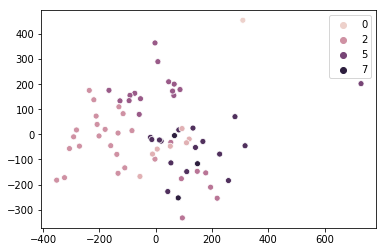

In [64]:
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(heart_data)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], cluster_assignments)

#### K-Means - DTW

In [86]:
def DTWDistance(s1, s2,w = 10):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [87]:
DTWDistance(heart_data[0, :], heart_data[1, :])

461.02556603895744

In [92]:
def LB_Keogh(s1,s2,r=10):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [97]:
LB_Keogh(heart_data[0, :], heart_data[1, :])

334.5489534814862

In [100]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print (counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

In [108]:
k_means_clust(list(heart_data), 4, 10)

1
2
3


TypeError: 'int' object is not iterable

In [101]:
k_means_clust(heart_data, 4, num_iter=200)

TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [75]:
clusterer = KMeansClusterer(8, lambda x, y: fastdtw.dtw(x, y, dist=euclidean)[0], repeats=1)
cluster_assignments = clusterer.cluster(heart_data, True)
#np.unique(cluster_assignments, return_counts=True)

KeyboardInterrupt: 

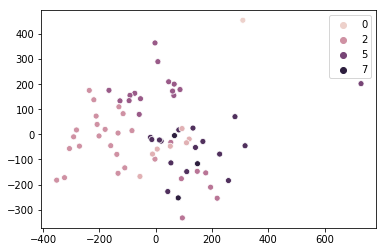

In [64]:
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(heart_data)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], cluster_assignments)